# Neural Network from Scratch in TensorFlow

# Task 1: Introduction and Importing Libraries

While it's easy to get started with the tensorflow with the keras api, it's still worth understanding how a slightly lower level implementation might work in tensorflow. So, I am going to implement here a Neural network in tf without the high level API like keras and the gradient descent algorithm with the help of TensorFlow's automatic differentiation to solve a multi-class classification problem. Datasets used: MNIST Handwritten digit dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nn_utils
%matplotlib inline

print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.4.1


# Task 2: Initializing Neural Network

In [2]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {} #Keeping track of weights and biases with these 2 dictionaries for different layers.
        self.b = {}
        
        self.dW = {} #Also keeping track of gradients for w and b respectively.
        self.db = {}
        
        self.setup()
# The upper code implements (passing the lasyers as a list) => net = NeuralNetwork([10, 100, 10]) #10 features and classes for each eg, 100 units in the hidden layer.
    def setup(self):
        for i in range(1, self.L): #0
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1]))) #1
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], 1))) #2
#0. For the 1st layer, it's always going to be yours i/p layer which has the features so no need to worry to much about that.             
#1. Initializing the weights : The key i simply represents the 2nd layer, or at index[1] bcoz the first one is just the no. of features.
#1. Setting the initial random value with random.uniform/normal, and the shape is going to be the number of nodes in this layer(i.e 2nd layer) by the number of nodes in the preceeding layer.
#2. Initializing the bias : Bias value is going to be simply broadcasted to the dot product of w & x, so no need to worry about the 2nd dimension..hence 1.

# Task 3: Forward Pass

Note:
1. We already have NN class but we are going to extend here it again just to organize the way so that it can be broken down into different code cells.
2. Here, X = batch of examples or initial value for the i/p from which the activation o/p is created through this forward_pass function by taking this X in calulating a linear o/p, activation o/p for the 1st layer, 2nd layer and so on.
3. X is going to have here some sort of batch size so the 2nd dimension is going to be the number of features. Say if you have 200 features and 50 examples then the shape of X is going to be 50/200 i.e 0.25, and that is the reason why we are transposing our weights here so Z will become 200 by whatever the number of nodes is there in this layer.

In [3]:
class NeuralNetwork(NeuralNetwork):
    def forward_pass(self, X):
        A = tf.convert_to_tensor(X, dtype=tf.float32) #A is X and not a activation function but calling it as A since doing it in a loop.
        for i in range(1, self.L): #for each layer calculating the o/p so starting again at index[1] or 2nd layer essentially.
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i]) #Z = linear o/p, matmul = matrix multiplication of A with transpose of the weight for this particular layer
            if i != self.L-1: #If the layer is not the final layer then : passing relu a.f
                A = tf.nn.relu(Z)
            else:             
                A = Z         #But if you're calculating activation for the final layer then A will reset to Z i.e Final Output. Since, the A.F is not going to be used in the next iteration as an i/p or else where in the final layer.
        return A              #linear sum => final layer

1. The "forward pass" refers to calculation process, values of the output layers from the inputs data. It's traversing through all neurons from first to last layer.
2. A loss function is calculated from the output values.
3. And then "backward pass" refers to process of counting changes in weights (de facto learning), using gradient descent algorithm (or similar). Computation is made from last layer, backward to the first layer.
4. Backward and forward pass makes together one "iteration".
5. During one iteration, you usually pass a subset of the data set, which is called "mini-batch" (if you pass all data at once, it is called "batch")
6. "Epoch" means passing the entire data set. One epoch contains number_of_items/batch_size iterations
7. The reason will get clearer but the basic idea is that we're going to use softmax cross entropy  with logits to calculate the loss on a batch.

# Task 4: Computing Loss and Updating Parameters

So, when we are using our model to train on a dataset, we'll be sending some batches of data and for those batches we will have a forward pass. Based on the result from the forward pass, the final o/p - we will compute loss and that'll be used to a backward propagation. With backward propagation we'll get some gradients back and then we'll use those gradients for parameters 'w' and 'b' for each layer to update the value for those parameters.

In [4]:
class NeuralNetwork(NeuralNetwork):
    def compute_loss(self, A, Y): #The first arg. needs to be a self since this is a class function. A = Final linear o/p and not a Activation o/p.
        loss = tf.nn.softmax_cross_entropy_with_logits(Y, A) #Careful: First arg Y not A!
        return tf.reduce_mean(loss) #The above function guesses the loss on the batch but still need to calc. the mean for this.
        #return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Y, A))
        #This loss will be used to calc. gradients for parameters w & b for each layer. And then update_params
    def update_params(self, lr): #lr=learning rate
        for i in range(1, self.L): #updating param. for all the layers except for the i/p layer ofcourse. :D
            self.W[i].assign_sub(lr * self.dW[i]) #Assigning a new value i.e all the gradients for this layer
            self.b[i].assign_sub(lr * self.db[i]) 

1. tf.nn.softmax computes the forward propagation through a softmax layer. You use it during evaluation of the model when you compute the probabilities that the model outputs, whereas tf.nn.softmax_cross_entropy_with_logits computes the cost for a softmax layer. It is only used during training.
2. In this function you need to provide just the logits and you don't actually need to provide the probability distribution that is done within that loss function.
3. The logits are the unnormalized log probabilities output the model (the values output before the softmax normalization is applied to them).
4. In contrast, tf.nn.softmax_cross_entropy_with_logits computes the cross entropy of the result after applying the softmax function (but it does it all together in a more mathematically careful way).

# Task 5: Predict and Info Functions

In [5]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X): #Just need the examples and return the predictions
        A = self.forward_pass(X) #getting the final layers o/p simply by using the forward pass 
        return tf.argmax(tf.nn.softmax(A), axis=1) #returning the predicted class directory, i.e the index with the max value. Specifier: looking at the argmax for the cols, so set axis = 1.
    
    def info(self): #Shows the number of params. we have in our NN, features, classes and diff, units in hidden layers
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

# Task 6: Training on Batch

Main training prcs happens in this function i.e forward pass for a batch, computation of cost or loss on that batch and then doing backpropagation and finding out the gradients and then updating the gradients so 

In [6]:
class NeuralNetwork(NeuralNetwork):
    def train_on_batch(self, X, Y, lr):  
        X = tf.convert_to_tensor(X, dtype=tf.float32) #X(eg) and Y(labels) batches might be in arrays,
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for key in self.W.keys(): #calc gradients for all the layers 
            self.dW[key] = tape.gradient(loss, self.W[key]) #If your loss is j, so ii's dj/dw for that layer
            self.db[key] = tape.gradient(loss, self.b[key])
        del tape
        self.update_params(lr)
        
        return loss.numpy()

# Task 7: Training on Complete Set

In [7]:
class NeuralNetwork(NeuralNetwork):
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'val_loss': [],
            'train_loss': [],
            'val_acc': []
        }
        
        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch {}'.format(e), end='.')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
                    
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            
            val_A = self.forward_pass(x_test)
            history['val_loss'].append(self.compute_loss(val_A, y_test).numpy())
            
            val_preds = self.predict(x_test)
            history['val_acc'].append(np.mean(np.argmax(y_test, axis=1) == val_preds.numpy()))
            print('Val Acc:', history['val_acc'][-1])
        return history

# Task 8: Application

11493376/11490434 [==============================] - 0s 0us/step


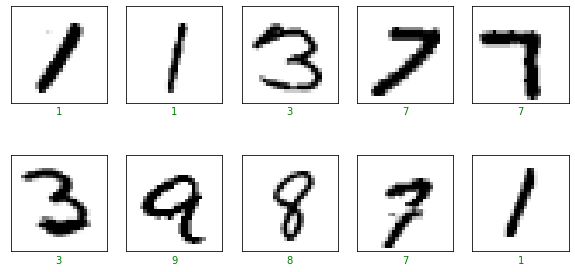

In [8]:
(x_train, y_train), (x_test, y_test) = nn_utils.load_data()
nn_utils.plot_random_examples(x_train, y_train).show()

In [9]:
net = NeuralNetwork([784, 128, 128, 10])
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [10]:
batch_size = 120
epochs = 5
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3

print('Steps per epoch:', steps_per_epoch)

Steps per epoch: 500


In [11]:
history = net.train(
    x_train, y_train,
    x_test, y_test,
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch 0...........Val Acc: 0.8035
Epoch 1...........Val Acc: 0.8344
Epoch 2...........Val Acc: 0.8484
Epoch 3...........Val Acc: 0.8525
Epoch 4...........Val Acc: 0.8619


# Task 9: Results

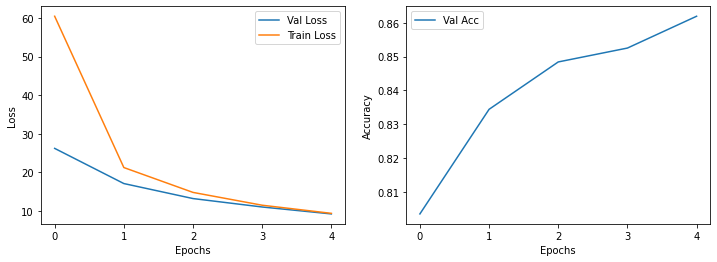

In [12]:
nn_utils.plot_results(history).show()

In [13]:
preds = net.predict(x_test)

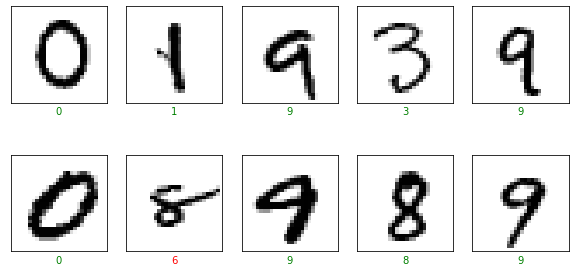

In [14]:
nn_utils.plot_random_examples(x_test, y_test, preds.numpy()).show()